<a href="https://colab.research.google.com/github/AditiSatsangi/Miscellaneous-Projects/blob/main/Flower_classification_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Flower Classification**

TensorFlow Hub is an online repository of already trained TensorFlow models that you can use. These models can either be used as is, or they can be used for Transfer Learning.

## Import

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [10]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Download flower dataset using Tensorflow Dataset

In [9]:
splits= ['train[:70%]', 'train[70%:]']
(train_examples, validation_examples),info= tfds.load(
    'tf_flowers',
    split= splits,
    as_supervised=True,
    with_info=True
)

num_examples= info.splits['train'].num_examples
num_classes= info.features['label'].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


# Information about the Flowers Dataset

In [11]:

for i, example_image in enumerate(train_examples.take(3)):
   print("Image {}  shape:{} ".format(i+1, example_image[0].shape))

Image 1  shape:(333, 500, 3) 
Image 2  shape:(212, 320, 3) 
Image 3  shape:(240, 320, 3) 


In [12]:

print('Total Number of Classes: {}'.format(num_classes))

Total Number of Classes: 5


In [13]:
for i, example in enumerate(train_examples.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformatting Images and Creating Batches

In [14]:
IMAGE_RES =  224

def format_image(image, label):
  image= tf.image.resize(image, (IMAGE_RES,IMAGE_RES ))/255.0
  return image, label

BATCH_SIZE =  32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

#**Transfer Learning with MobileNet Model**

## Using Tensorflow Hub

## Creating a Feature Extractor

In [23]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape= (IMAGE_RES,IMAGE_RES, 3))

## Freezing the Pre-Trained Model

In [24]:
feature_extractor.trainable= False

## Attaching a classification head

In [25]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(5)]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the model

In [27]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6


history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 203s 2s/step - loss: 0.7557 - accuracy: 0.7306 - val_loss: 0.4374 - val_accuracy: 0.8492
Epoch 2/6
81/81 [==============================] - 210s 3s/step - loss: 0.3813 - accuracy: 0.8684 - val_loss: 0.3544 - val_accuracy: 0.8801
Epoch 3/6
81/81 [==============================] - 194s 2s/step - loss: 0.2996 - accuracy: 0.9007 - val_loss: 0.3217 - val_accuracy: 0.8910
Epoch 4/6
81/81 [==============================] - 189s 2s/step - loss: 0.2525 - accuracy: 0.9206 - val_loss: 0.3193 - val_accuracy: 0.9010
Epoch 5/6
81/81 [==============================] - 135s 2s/step - loss: 0.2232 - accuracy: 0.9292 - val_loss: 0.2928 - val_accuracy: 0.9074
Epoch 6/6
81/81 [==============================] - 137s 2s/step - loss: 0.1886 - accuracy: 0.9498 - val_loss: 0.2916 - val_accuracy: 0.9028


# Plotting Training and Validation Graphs

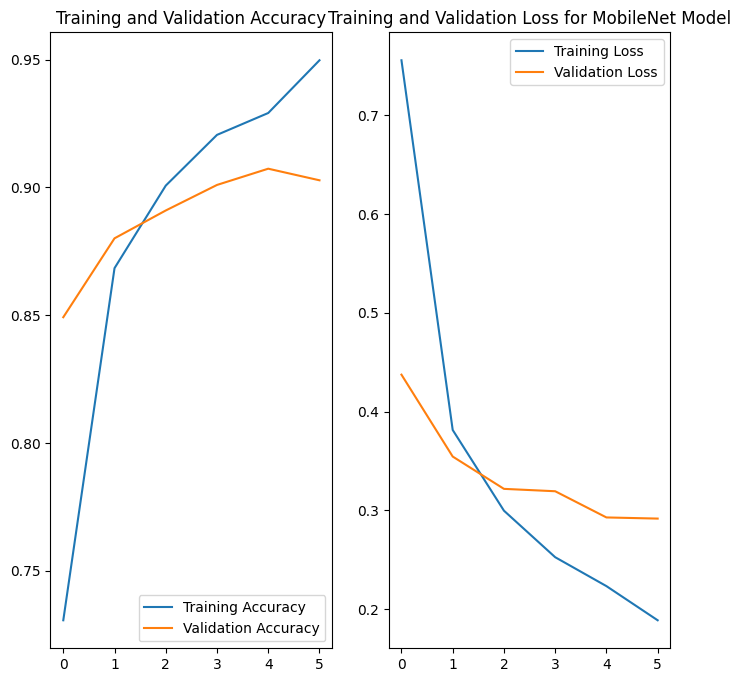

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for MobileNet Model')
plt.show()


# Predictions

In [29]:
class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

# Creating an Image Batch and Make Predictions

In [32]:
# Get an iterator from the prefetch dataset
train_iterator = iter(train_batches)

# Get the next batch using the iterator
image_batch, label_batch = next(train_iterator)


In [33]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 2s 2s/step


array(['dandelion', 'roses', 'tulips', 'tulips', 'tulips', 'tulips',
       'roses', 'daisy', 'sunflowers', 'daisy', 'dandelion', 'tulips',
       'daisy', 'daisy', 'sunflowers', 'roses', 'daisy', 'roses', 'daisy',
       'daisy', 'daisy', 'daisy', 'roses', 'sunflowers', 'dandelion',
       'roses', 'sunflowers', 'roses', 'dandelion', 'dandelion', 'tulips',
       'daisy'], dtype='<U10')

# Printing True Labels and Predicted Indices

In [34]:
print("Labels:" , label_batch)
print("Predicted labels:", predicted_ids)

Labels: tf.Tensor([0 2 2 2 2 2 4 1 3 1 0 2 1 1 3 4 1 4 1 1 1 1 4 3 0 4 3 4 0 0 2 1], shape=(32,), dtype=int64)
Predicted labels: [0 4 2 2 2 2 4 1 3 1 0 2 1 1 3 4 1 4 1 1 1 1 4 3 0 4 3 4 0 0 2 1]


# Plotting Model Predictions



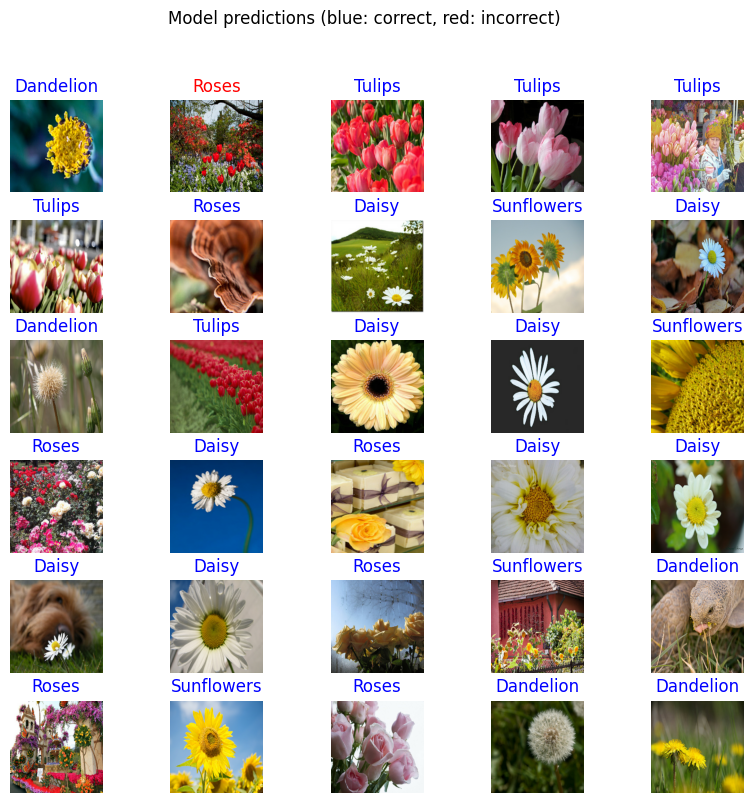

In [35]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# **Perform Transfer Learning with the Inception Model**

## Creating a Feature Extractor

In [15]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape= (IMAGE_RES,IMAGE_RES, 3))

## Freezing the Pre-Trained Model

In [16]:
feature_extractor.trainable= False

# Attaching a classification head



In [17]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(5)]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


## Training the model

In [18]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6


history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 461s 6s/step - loss: 0.7689 - accuracy: 0.7291 - val_loss: 0.5252 - val_accuracy: 0.8084
Epoch 2/6
81/81 [==============================] - 444s 6s/step - loss: 0.4329 - accuracy: 0.8427 - val_loss: 0.4570 - val_accuracy: 0.8338
Epoch 3/6
81/81 [==============================] - 435s 5s/step - loss: 0.3364 - accuracy: 0.8871 - val_loss: 0.3860 - val_accuracy: 0.8629
Epoch 4/6
81/81 [==============================] - 434s 5s/step - loss: 0.2791 - accuracy: 0.9062 - val_loss: 0.3583 - val_accuracy: 0.8638
Epoch 5/6
81/81 [==============================] - 422s 5s/step - loss: 0.2424 - accuracy: 0.9229 - val_loss: 0.3823 - val_accuracy: 0.8629
Epoch 6/6
81/81 [==============================] - 424s 5s/step - loss: 0.2183 - accuracy: 0.9350 - val_loss: 0.3617 - val_accuracy: 0.8656


# Plotting Training and Validation Graphs

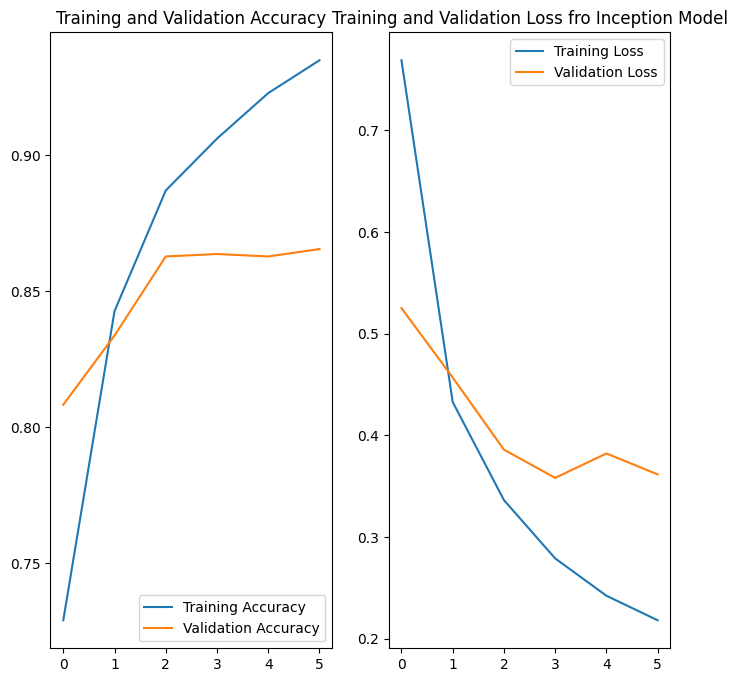

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss fro Inception Model')
plt.show()


## Predictions

In [23]:
class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

# Creating an Image Batch and Make Predictions

In [24]:
# Get an iterator from the prefetch dataset
train_iterator = iter(train_batches)

# Get the next batch using the iterator
image_batch, label_batch = next(train_iterator)


In [25]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 6s 6s/step


array(['roses', 'tulips', 'tulips', 'roses', 'tulips', 'dandelion',
       'dandelion', 'sunflowers', 'dandelion', 'tulips', 'roses', 'daisy',
       'roses', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'dandelion',
       'sunflowers', 'daisy', 'tulips', 'daisy', 'roses', 'daisy',
       'tulips', 'dandelion', 'roses', 'sunflowers', 'dandelion', 'daisy',
       'daisy', 'dandelion'], dtype='<U10')

# Printing True Labels and Predicted Indices

In [26]:
print("Labels:" , label_batch)
print("Predicted labels:", predicted_ids)

Labels: tf.Tensor([4 2 0 4 2 0 0 3 0 2 4 1 4 1 0 2 3 0 2 2 2 1 4 1 2 0 4 3 0 1 1 0], shape=(32,), dtype=int64)
Predicted labels: [4 2 2 4 2 0 0 3 0 2 4 1 4 1 0 2 3 0 3 1 2 1 4 1 2 0 4 3 0 1 1 0]


# Plotting Model Predictions

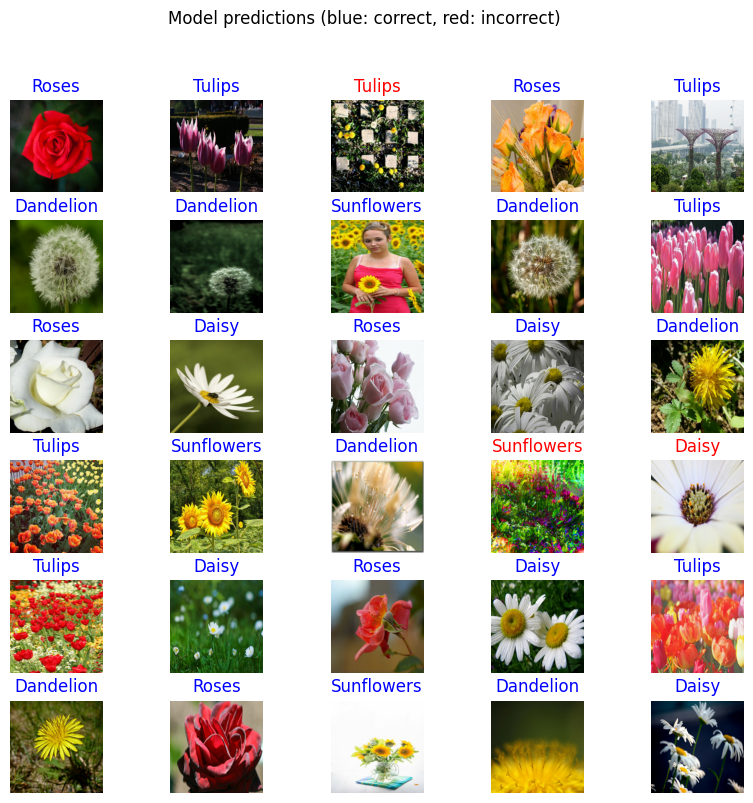

In [27]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")